In [1]:
import time
import os
import tensorflow as tf
import json
import pickle
import copy
import numpy as np
from xlrd import open_workbook
from collections import Counter
import nltk
import re
import pickle
from build_vocab import Vocabulary
from math import floor
import cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


C:\Users\Nahian\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Action to id map

In [3]:
actions_map = dict()
actions_map['Down'] = 0
actions_map['Left'] = 1
actions_map['Right'] = 2
actions_map['Up'] = 3
actions_map['Wait'] = 4

# Load and preprocess data

In [4]:
def load_images(current_image_dir, next_image_dir, good_ids, tr_indices):
    current_images = os.listdir(current_image_dir)
    current_images = sorted(current_images ,key = numericalSort)
    
    next_images = os.listdir(next_image_dir)
    next_images = sorted(next_images ,key = numericalSort)
    num_images = len(current_images)
    
    cur_training_images = []
    next_training_images = []
    cur_test_images = []
    next_test_images = []
    for i, file in enumerate(current_images):
        if i in good_ids:
            if good_ids[tr_indices[0]]<=i and i<=good_ids[tr_indices[1]]:
                cur_training_images.append(file)
                next_training_images.append(next_images[i])
            else:
                cur_test_images.append(file)
                next_test_images.append(next_images[i])
    
    return cur_training_images, next_training_images, cur_test_images, next_test_images

In [5]:
def load_data(data_file, vocab_path):
    wb = open_workbook(data_file)
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    #vocab = vocab
    #read the rationalizations from the excel file and create a list of training/testing rationalizations. 
    for sheet in wb.sheets():
        number_of_rows = sheet.nrows
        number_of_columns = sheet.ncols
        rationalizations = []
        items = []
        rows = []
        lengths = []
        max_length = 0
        
        bad_worker_ids = ['A2CNSIECB9UP05','A23782O23HSPLA','A2F9ZBSR6AXXND','A3GI86L18Z71XY','AIXTI8PKSX1D2','A2QWHXMFQI18GQ','A3SB7QYI84HYJT',
'A2Q2A7AB6MMFLI','A2P1KI42CJVNIA','A1IJXPKZTJV809','A2WZ0RZMKQ2WGJ','A3EKETMVGU2PM9','A1OCEC1TBE3CWA','AE1RYK54MH11G','A2ADEPVGNNXNPA',
'A15QGLWS8CNJFU','A18O3DEA5Z4MJD','AAAL4RENVAPML','A3TZBZ92CQKQLG','ABO9F0JD9NN54','A8F6JFG0WSELT','ARN9ET3E608LJ','A2TCYNRAZWK8CC',
'A32BK0E1IPDUAF','ANNV3E6CIVCW4','AXMQBHHU22TSP','AKATSYE8XLYNL','A355PGLV2ID2SX','A55CXM7QR7R0N','A111ZFNLXK1TCO']
        
        good_ids = []
        good_rationalizations = []
        actions = []
        counter = Counter()
        for row in range(1, number_of_rows):
            values = []
            worker_id = sheet.cell(row,0).value
            if worker_id not in bad_worker_ids:
                good_ids.append(row-1)
                line = sheet.cell(row,4).value
                tokens = nltk.tokenize.word_tokenize(line.lower())
                # if tokens!=[]:
                _action = sheet.cell(row,2).value
                actions.append(actions_map[_action])
                line = line.lower()
                good_rationalizations.append(line)
                line = re.sub('[^a-z\ ]+', " ", line)
                words = line.split()
                length = len(tokens)
                lengths.append(length)
                if length>max_length:
                    max_length = length
                for index,word in enumerate(tokens): 
                    tokens[index] = vocab.word2idx[word]
                rationalizations.append(words)
        rationalizations=[np.array(xi) for xi in rationalizations]

    split = int(floor((90.0/100)*len(rationalizations)))
    
    # zzzz = nltk.tokenize.word_tokenize(' lksdfjoisd posidjf')
    # print(zzzz)
    # exit(0)
    tr = slice(0,split)
    tr_indices = [0,split-1]
    te_indices = [split,len(rationalizations)-1]
    te = slice(split,len(rationalizations))
    training_rationalizations = good_rationalizations[tr]
    testing_rationalizations = good_rationalizations[te]
    training_actions = actions[tr]
    testing_actions = actions[te]
    # print(good_rationalizations)
    # print(self.training_rationalizations)
    # for r in self.training_rationalizations:
    # 	if r==None:
    # 		print("first")
    # 		exit(0)
    # exit(0)
    training_rationalizations_text = good_rationalizations[tr]
    testing_rationalizations_text = good_rationalizations[te]
    
    
    #current_image_dir = self.current_image_dir
    #next_image_dir = self.next_image_dir
    #output_dir = self.output_dir
    #concatenated_images_dir = self.concatenated_images_dir
    #subtracted_images_dir = self.subtracted_training_images_dir
    #image_size = [self.image_size, self.image_size]
    #image preprocessing
    #crop and resize images. 
    
    return good_ids, tr_indices, te_indices, training_rationalizations, testing_rationalizations, training_actions, testing_actions, vocab
    


# Global Parameters

In [6]:
explanation_lstm_dim = 512
batch_size = 8
width = 320
height = 320
depth = 3
max_words = 40
n_words = 1000
word_embed_dim = 512
fc1_size = 4096
image_embedding_size = 2048
dim_hidden = 512
comb_embedding_size = explanation_lstm_dim + dim_hidden
num_output = 5
drop_out_rate = 0.7
max_rationalization_len = max_words
learning_rate = 0.001
max_epoch = 101
dim_att = 1024

# Convert explanation texts to a matrix of word id

In [7]:
def create_rationalization_matrix(rationalizations, vocab):
    rationalization_matrix = []
    sequence_lenght_arr = []
    for sent in rationalizations:
        sent = sent.replace("'","")
        sent = sent.strip()
        words = sent.lower().split(' ')
        
        ration_sent = np.zeros([ max_rationalization_len ], dtype=np.int32)
        ration_sent[0] = 1
        idx = 1
    
        for k, word in enumerate(words):
            if idx == max_rationalization_len:
                break
            if word in vocab.word2idx:
                ration_sent[idx] = vocab.word2idx[word]
            else:
                ration_sent[idx] = 3
            idx +=1
        
        if idx < max_rationalization_len:
            ration_sent[idx] = 2
            idx += 1
        rationalization_matrix.append(ration_sent)
        sequence_lenght_arr.append(idx)

    return rationalization_matrix, sequence_lenght_arr

In [8]:
def lstm_cell(size):
    return tf.contrib.rnn.BasicLSTMCell(size, reuse=tf.AUTO_REUSE)

In [9]:
explanation_lstm = tf.contrib.rnn.MultiRNNCell([lstm_cell(explanation_lstm_dim) for _ in range(2)])

In [10]:
W_embeddings = tf.Variable(tf.constant(0.0, shape=[n_words, word_embed_dim]), trainable=True, name="wemb")

In [11]:
embed_image_W = tf.Variable(tf.random_uniform([image_embedding_size, dim_hidden], -0.08, 0.08), name='embed_image_W')
embed_image_b = tf.Variable(tf.random_uniform([dim_hidden], -0.08, 0.08), name='embed_image_b')

In [12]:
embed_scor_W = tf.Variable(tf.random_uniform([comb_embedding_size, num_output], -0.08, 0.08), name='embed_scor_W')
embed_scor_b = tf.Variable(tf.random_uniform([num_output], -0.08, 0.08), name='embed_scor_b')

# The Convolutional Neural Network to encode the image

In [13]:
def image_encoder(img_input):
    with tf.name_scope("conv1"):
        conv1 = tf.layers.conv2d(img_input, 32, 3, activation=tf.nn.relu)
        conv1 = tf.layers.conv2d(conv1, 32, 3, activation=tf.nn.relu)
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
        print("conv1: ",conv1)
    with tf.name_scope("conv2"):
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        conv2 = tf.layers.conv2d(conv2, 64, 3, activation=tf.nn.relu)
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
        print("conv2: ",conv2)
    with tf.name_scope("conv3"):
        conv3 = tf.layers.conv2d(conv2, 128, 3, activation=tf.nn.relu)
        conv3 = tf.layers.conv2d(conv3, 128, 3, activation=tf.nn.relu)
        conv3 = tf.layers.max_pooling2d(conv3, 2, 2)
        print("conv3: ",conv3)
    with tf.name_scope("conv4"):
        conv4 = tf.layers.conv2d(conv3, 128, 3, activation=tf.nn.relu)
        conv4 = tf.layers.max_pooling2d(conv4, 2, 2)
        print("conv4: ",conv4)
    with tf.name_scope("conv5"):
        conv5 = tf.layers.conv2d(conv4, 256, 3, activation=tf.nn.relu)
        conv5 = tf.layers.max_pooling2d(conv5, 2, 2)
        print("conv5: ",conv5)
    with tf.name_scope("flatten"):
        flattened = tf.contrib.layers.flatten(conv5)
        print("flattened: ", flattened)
        
    with tf.name_scope("fc1"):
        fc1 = tf.layers.dense(flattened, fc1_size) 
    with tf.name_scope("fc"):
        fc = tf.layers.dense(fc1, image_embedding_size)
    
    return fc

# Attention Layer

In [14]:
attn_w1 = tf.layers.Dense(512)
attn_W2 = tf.layers.Dense(512)
attn_V = tf.layers.Dense(1)

In [3]:
def attention(exp_out, exp_hidden, image_emb):
    hidden_with_time_axis = tf.expand_dims(exp_hidden, 1)
    att1 = attn_w1(exp_out)
    att2 = attn_W2(hidden_with_time_axis)
    score = attn_V(tf.nn.tanh(att1 + att2))
    #print("score: ", score)
    attention_weights = tf.nn.softmax(score)
    #print("attention_weights",attention_weights)
    context_vector = attention_weights * exp_out
    context_vector = tf.reduce_sum(context_vector, axis=1)
    #print("context_vector", context_vector)
    comb_emb = tf.concat([context_vector, image_emb], axis=-1)
    #print("comb_emb", comb_emb)
    return attention_weights, comb_emb
    

# Build the architecture to train the model

In [4]:
def build_model():
    image = tf.placeholder(tf.float32, [batch_size, width, height, depth])
    explanation = tf.placeholder(tf.int32, [batch_size, max_words])
    explanation_sequence_length = tf.placeholder(tf.int32, [batch_size])
    action = tf.placeholder(tf.int32, [batch_size]) 
        
    state = explanation_lstm.zero_state(batch_size, tf.float32)
    loss = 0.0
    with tf.variable_scope("encoder"):
        text_embedding = tf.nn.embedding_lookup(W_embeddings, explanation)
        
        with tf.variable_scope('explanation_context'):
            exp_outputs, state = tf.nn.dynamic_rnn(explanation_lstm, 
                                                   inputs = text_embedding, 
                                                   sequence_length= explanation_sequence_length,
                                                   initial_state = state,
                                                   dtype=tf.float32)
        
        exp_embedding = tf.reshape(tf.transpose(state, [2, 1, 0, 3]), [batch_size, -1])
        
        image_emb = image_encoder(image)
        
        image_emb = tf.nn.xw_plus_b(image_emb, embed_image_W, embed_image_b)
        image_emb = tf.nn.relu(image_emb)
        
        #attention models
        with tf.variable_scope("att1"):
            prob_att1, comb_emb = attention(exp_outputs, exp_embedding, image_emb)

        comb_emb = tf.nn.dropout(comb_emb, 1 - drop_out_rate)
        
        scores_emb = tf.nn.xw_plus_b(comb_emb, embed_scor_W, embed_scor_b) 
        
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=action, logits=scores_emb)
        
        _action = tf.reshape(action, [batch_size, -1])
        onehot_action = tf.one_hot(_action, depth = num_output)
        onehot_action = tf.reshape(onehot_action, [batch_size, -1])
        
        prediction = tf.nn.softmax(scores_emb)
        correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(onehot_action, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

        # Calculate loss
        loss = tf.reduce_mean(cross_entropy)
        
        return loss, accuracy, image, explanation, explanation_sequence_length, action, prediction
    

# Generate the architecture to use during test

In [5]:
def build_generator():
    image = tf.placeholder(tf.float32, [batch_size, width, height, depth])
    explanation = tf.placeholder(tf.int32, [batch_size, max_words])
    explanation_sequence_length = tf.placeholder(tf.int32, [batch_size])
    action = tf.placeholder(tf.int32, [batch_size]) 
        
    state = explanation_lstm.zero_state(batch_size, tf.float32)
    loss = 0.0
    with tf.variable_scope("encoder"):
        text_embedding = tf.nn.embedding_lookup(W_embeddings, explanation)
        
        with tf.variable_scope('explanation_context'):
            exp_outputs, state = tf.nn.dynamic_rnn(explanation_lstm, 
                                                   inputs = text_embedding, 
                                                   sequence_length= explanation_sequence_length,
                                                   initial_state = state,
                                                   dtype=tf.float32)
        
        exp_embedding = tf.reshape(tf.transpose(state, [2, 1, 0, 3]), [batch_size, -1])
        
        image_emb = image_encoder(image)
        
        image_emb = tf.nn.xw_plus_b(image_emb, embed_image_W, embed_image_b)
        image_emb = tf.nn.relu(image_emb)
        
        with tf.variable_scope("att1"):
            prob_att1, comb_emb = attention(exp_outputs, exp_embedding, image_emb)

        
        scores_emb = tf.nn.xw_plus_b(comb_emb, embed_scor_W, embed_scor_b) 
        
        _action = tf.reshape(action, [batch_size, -1])
        onehot_action = tf.one_hot(_action, depth = num_output)
        onehot_action = tf.reshape(onehot_action, [batch_size, -1])
        
        prediction = tf.nn.softmax(scores_emb)
        result_action = tf.argmax(prediction, 1)
        correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(onehot_action, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

        return accuracy, image, explanation, explanation_sequence_length, action, prediction, result_action
    

In [20]:
model_path = './models_attention/'

In [21]:
def train(cur_image_dir, next_image_dir):
    
    good_ids, training_indices, testing_indices, training_rationalizations, testing_rationalizations, trn_act, tst_act, vocab = load_data("Turk_Master_File.xlsx", 'data/vocab_frogger.pkl')
    cur_training_images, next_training_images, cur_test_images, next_test_images = load_images(current_image_dir, next_image_dir, good_ids, training_indices)

    rationalization_matrix, ration_sqn_len = create_rationalization_matrix(training_rationalizations, vocab)
    num_train = len(training_rationalizations)
    rationalization_matrix = np.array(rationalization_matrix)
    ration_sqn_len = np.array(ration_sqn_len)
    cur_training_images = np.array(cur_training_images)
    trn_act = np.array(trn_act)
    tf_loss, tf_acc, tf_image, tf_explanation, tf_explanation_sequence_length, tf_action, tf_pred = build_model()
    
    sess = tf.InteractiveSession()
    
    with tf.device('/cpu:0'):
        saver = tf.train.Saver(max_to_keep=100)

    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(tf_loss)
    tf.global_variables_initializer().run()
    loss_arr = []
    acc_arr = []
    for epoch in range(0, max_epoch):
        rationalization_matrix, ration_sqn_len, cur_training_images, trn_act = shuffle(
            rationalization_matrix, ration_sqn_len, cur_training_images, trn_act)

        #print(np.any(np.isnan(trn_act)))
        tStart = time.time()
        niter = 0
        sum_loss = 0
        sum_accuracy = 0
        for current_batch_start_idx in range(0,num_train,batch_size):
            if current_batch_start_idx + batch_size < num_train:
                current_batch_file_idx = range(current_batch_start_idx,current_batch_start_idx+batch_size)
            else:
                current_batch_file_idx = range(current_batch_start_idx,num_train)


            current_ration_text = rationalization_matrix[current_batch_file_idx,:]
            current_sqn_len = ration_sqn_len[current_batch_file_idx]
            current_img_list = cur_training_images[current_batch_file_idx]
            current_actions = trn_act[current_batch_file_idx]
            current_imgs_data = []
            for img in current_img_list:
                img_path = os.path.join(cur_image_dir, img)
                img_arr = cv2.imread(img_path)
                resized_img = cv2.resize(img_arr, (320,320))
                current_imgs_data.append(resized_img)

            current_imgs_data = np.array(current_imgs_data)
            
            
            if len(current_ration_text) == batch_size:
                _, loss, accuracy, prediction = sess.run([train_op, tf_loss, tf_acc, tf_pred],
                    feed_dict={
                        tf_image: current_imgs_data,
                        tf_explanation: current_ration_text,
                        tf_explanation_sequence_length: current_sqn_len,
                        tf_action: current_actions})
                niter +=1
                sum_loss += loss
                sum_accuracy += accuracy
                
        
        avg_loss = sum_loss / niter
        avg_acc = sum_accuracy/ niter
        print("epoch: ", epoch, " loss: ", avg_loss, " accuracy: ", avg_acc, " time: ", time.time() - tStart)
        f_acc= open("train_acc_attention.txt","a+")
        f_acc.write("epoch: "+ str(epoch) + " "+"Accuracy is: " + str(avg_acc)+ "%\n")
        f_acc.close()
        loss_arr.append(avg_loss)
        acc_arr.append(avg_acc)
        
        if np.mod(epoch, 10) == 0:
            print ("Epoch ", epoch, " is done. Saving the model ...")
            saver.save(sess, os.path.join(model_path, 'frogger_model_attention'), global_step=epoch)
        
    return loss_arr, acc_arr

In [22]:
current_image_dir = 'data/Frogger_Turk/Currrent_State'
next_image_dir = 'data/Frogger_Turk/Next_State'
loss_arr, acc_arr = train(current_image_dir, next_image_dir)

conv1:  Tensor("encoder/conv1/max_pooling2d/MaxPool:0", shape=(8, 158, 158, 32), dtype=float32)
conv2:  Tensor("encoder/conv2/max_pooling2d/MaxPool:0", shape=(8, 77, 77, 64), dtype=float32)
conv3:  Tensor("encoder/conv3/max_pooling2d/MaxPool:0", shape=(8, 36, 36, 128), dtype=float32)
conv4:  Tensor("encoder/conv4/max_pooling2d/MaxPool:0", shape=(8, 17, 17, 128), dtype=float32)
conv5:  Tensor("encoder/conv5/max_pooling2d/MaxPool:0", shape=(8, 7, 7, 256), dtype=float32)
flattened:  Tensor("encoder/flatten/Flatten/flatten/Reshape:0", shape=(8, 12544), dtype=float32)
score:  Tensor("encoder/att1/dense_3/BiasAdd:0", shape=(8, 40, 1), dtype=float32)
attention_weights Tensor("encoder/att1/Reshape_1:0", shape=(8, 40, 1), dtype=float32)
context_vector Tensor("encoder/att1/Sum:0", shape=(8, 512), dtype=float32)
comb_emb Tensor("encoder/att1/concat_1:0", shape=(8, 1024), dtype=float32)
epoch:  0  loss:  1.742277669483388  accuracy:  0.4519230769230769  time:  84.36119890213013
epoch:  1  loss:  1

epoch:  77  loss:  0.14290106735886599  accuracy:  0.9519230769230769  time:  56.32093334197998
epoch:  78  loss:  0.1305394832474681  accuracy:  0.9585798816568047  time:  56.6881959438324
epoch:  79  loss:  0.1161467978756974  accuracy:  0.9674556213017751  time:  56.27603888511658
epoch:  80  loss:  0.12187720127761938  accuracy:  0.9607988165680473  time:  56.31303954124451
epoch:  81  loss:  0.11045497568109287  accuracy:  0.9659763313609467  time:  56.354652881622314
epoch:  82  loss:  0.10934214188563003  accuracy:  0.9681952662721893  time:  55.96854567527771
epoch:  83  loss:  0.10764131464474674  accuracy:  0.9704142011834319  time:  56.255192041397095
epoch:  84  loss:  0.10202689967379966  accuracy:  0.9659763313609467  time:  56.28541159629822
epoch:  85  loss:  0.08403111759059341  accuracy:  0.977810650887574  time:  56.50040006637573
epoch:  86  loss:  0.07582220101292306  accuracy:  0.9822485207100592  time:  56.137359619140625
epoch:  87  loss:  0.07190684600355732  a

# Plot the training loss

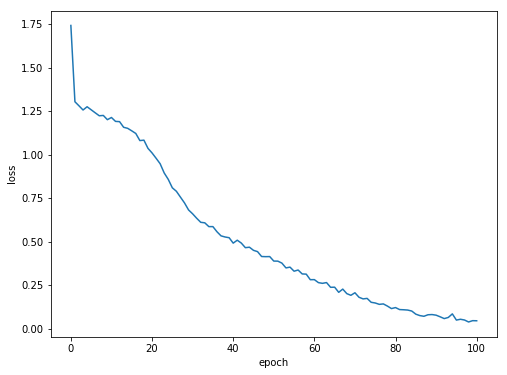

In [25]:
plt.figure(figsize=(8,6))
plt.plot(loss_arr)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [22]:
def test(cur_image_dir, next_image_dir):
    good_ids, training_indices, testing_indices, training_rationalizations, testing_rationalizations, trn_act, tst_act, vocab = load_data("Turk_Master_File.xlsx", 'data/vocab_frogger.pkl')
    cur_training_images, next_training_images, cur_test_images, next_test_images = load_images(current_image_dir, next_image_dir, good_ids, training_indices)
    
    rationalization_matrix, ration_sqn_len = create_rationalization_matrix(testing_rationalizations, vocab)
    num_test = len(testing_rationalizations)
    rationalization_matrix = np.array(rationalization_matrix)
    ration_sqn_len = np.array(ration_sqn_len)
    cur_training_images = np.array(cur_training_images)
    trn_act = np.array(trn_act)
    tf_accuracy, tf_image, tf_explanation, tf_explanation_sequence_length, tf_action, tf_prediction, tf_out_action = build_generator()
    
    sess = tf.Session()
    with tf.device('/cpu:0'):
        saver = tf.train.Saver()
        saver.restore(sess, os.path.join(model_path, 'frogger_model_attention-100'))


        
    tStart = time.time()
    
    sum_accuracy = 0
    niter = 0
    for current_batch_start_idx in range(0,num_test,batch_size):
        if current_batch_start_idx + batch_size < num_test:
            current_batch_file_idx = range(current_batch_start_idx,current_batch_start_idx+batch_size)
        else:
            current_batch_file_idx = range(current_batch_start_idx,num_test)

            #print(current_batch_file_idx)

        current_ration_text = rationalization_matrix[current_batch_file_idx,:]
        current_sqn_len = ration_sqn_len[current_batch_file_idx]
        current_img_list = cur_training_images[current_batch_file_idx]
        current_actions = trn_act[current_batch_file_idx]
        current_imgs_data = []
        for img in current_img_list:
            img_path = os.path.join(cur_image_dir, img)
            img_arr = cv2.imread(img_path)
            resized_img = cv2.resize(img_arr, (320,320))
            current_imgs_data.append(resized_img)

        current_imgs_data = np.array(current_imgs_data)
            
            
        if len(current_ration_text) == batch_size:
            accuracy, prediction, out_action = sess.run([tf_accuracy, tf_prediction, tf_out_action],
                                            feed_dict={
                                                tf_image: current_imgs_data,
                                                tf_explanation: current_ration_text,
                                                tf_explanation_sequence_length: current_sqn_len,
                                                tf_action: current_actions})
            print("original actions: ", current_actions)
            print("prediction: ", prediction)
            print("output action: ", out_action)
            niter +=1
            sum_accuracy += accuracy
                
        
    avg_acc = sum_accuracy/ niter
    print("accuracy: ", avg_acc, " time: ", time.time() - tStart)
        
    return

In [23]:
current_image_dir = 'data/Frogger_Turk/Currrent_State'
next_image_dir = 'data/Frogger_Turk/Next_State'
test(current_image_dir, next_image_dir)

conv1:  Tensor("encoder/conv1/max_pooling2d/MaxPool:0", shape=(1, 158, 158, 32), dtype=float32)
conv2:  Tensor("encoder/conv2/max_pooling2d/MaxPool:0", shape=(1, 77, 77, 64), dtype=float32)
conv3:  Tensor("encoder/conv3/max_pooling2d/MaxPool:0", shape=(1, 36, 36, 128), dtype=float32)
conv4:  Tensor("encoder/conv4/max_pooling2d/MaxPool:0", shape=(1, 17, 17, 128), dtype=float32)
conv5:  Tensor("encoder/conv5/max_pooling2d/MaxPool:0", shape=(1, 7, 7, 256), dtype=float32)
flattened:  Tensor("encoder/flatten/Flatten/flatten/Reshape:0", shape=(1, 12544), dtype=float32)
score:  Tensor("encoder/att1/dense_3/BiasAdd:0", shape=(1, 40, 1), dtype=float32)
attention_weights Tensor("encoder/att1/Reshape_1:0", shape=(1, 40, 1), dtype=float32)
context_vector Tensor("encoder/att1/Sum:0", shape=(1, 512), dtype=float32)
comb_emb Tensor("encoder/att1/concat_1:0", shape=(1, 1024), dtype=float32)
INFO:tensorflow:Restoring parameters from ./models_attention/frogger_model_attention-100
original actions:  [3]


original actions:  [1]
prediction:  [[5.645326e-06 8.133337e-03 8.162616e-05 6.895897e-01 3.021897e-01]]
output action:  [3]
original actions:  [1]
prediction:  [[4.7825673e-05 9.0041239e-04 8.1005319e-06 2.4021374e-01 7.5882989e-01]]
output action:  [4]
original actions:  [3]
prediction:  [[1.28216579e-05 2.00807070e-03 1.19408745e-04 9.95699525e-01
  2.16021179e-03]]
output action:  [3]
original actions:  [1]
prediction:  [[3.58956808e-04 5.45715809e-01 1.08150794e-04 2.70195037e-01
  1.83622077e-01]]
output action:  [1]
original actions:  [1]
prediction:  [[1.2776614e-04 2.0020621e-01 1.4304569e-02 3.6362424e-02 7.4899906e-01]]
output action:  [4]
original actions:  [1]
prediction:  [[2.9600274e-06 7.2850651e-01 4.6901354e-03 6.4037502e-04 2.6616001e-01]]
output action:  [1]
original actions:  [1]
prediction:  [[1.7237755e-06 9.8363459e-01 1.2536001e-04 7.1912850e-03 9.0469262e-03]]
output action:  [1]
original actions:  [3]
prediction:  [[1.3471054e-05 1.7465208e-01 5.3822108e-02 7

original actions:  [1]
prediction:  [[1.1273368e-06 1.0254549e-04 3.7428373e-07 7.6910484e-01 2.3079108e-01]]
output action:  [3]
original actions:  [1]
prediction:  [[4.9715647e-05 2.1229625e-04 6.1621970e-05 9.9029070e-01 9.3856743e-03]]
output action:  [3]
original actions:  [1]
prediction:  [[1.2121102e-02 8.8646094e-04 7.8342976e-03 9.7050560e-01 8.6524719e-03]]
output action:  [3]
original actions:  [1]
prediction:  [[0.00154356 0.00521481 0.00776558 0.00303736 0.98243874]]
output action:  [4]
original actions:  [1]
prediction:  [[1.9606744e-06 2.7095965e-17 1.1337019e-10 9.9982965e-01 1.6835614e-04]]
output action:  [3]
original actions:  [1]
prediction:  [[5.8754313e-06 1.0375896e-06 1.9489042e-05 6.8514897e-03 9.9312204e-01]]
output action:  [4]
original actions:  [1]
prediction:  [[4.6559658e-06 2.3550072e-12 2.0901613e-08 4.3379840e-02 9.5661551e-01]]
output action:  [4]
original actions:  [1]
prediction:  [[8.3461809e-06 3.1624094e-07 1.2019424e-04 9.9920791e-01 6.6317868e-

# Plot the training and testing accuracy

In [24]:
training = [0.441, 0.529,0.609,0.769, 0.836, 0.893, 0.931, 0.952, 0.974, 0.988, 0.993]

In [25]:
testing = [0.483, 0.503, 0.51, 0.444, 0.46, 0.44, 0.53, 0.543, 0.57, 0.583, 0.61]

In [33]:
epoch = [0,10,20,30,40,50,60,70,80,90,100]

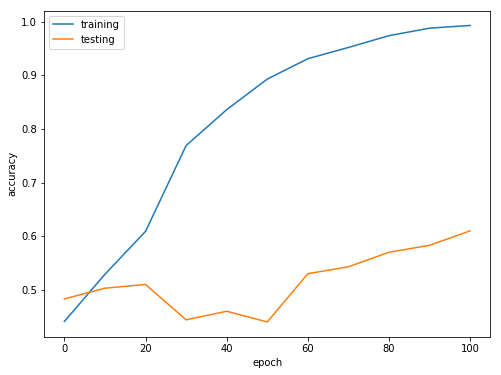

In [44]:
plt.figure(figsize=(8,6))
plt.plot(epoch, training, label='training')
plt.plot(epoch, testing, label='testing')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()
